# IN6227 Assignment 1.2

Compare kNN and DT implementations from sklearn.

## Import

In [87]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

pd.set_option('display.max_columns', None)

## Read & Explore Data Files

In [88]:
# insert table column names
column_names = 'age,workclass,fnlwgt,education,education-num,marital status,occupation,\
    relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary'.split(',')

# handle files from the original downloaded zip 
train_set = pd.read_csv('dataset/adult.data', names=column_names)
test_set = pd.read_csv('dataset/adult.test', names=column_names)

# Explore dataset
print(f'imported train set size: {len(train_set)}')
print(f'imported test set size: {len(test_set)}')
train_set.describe(include='all')

imported train set size: 32561
imported test set size: 16281


,age,workclass,fnlwgt,education,education-num,marital status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


## Data Preprocessing

In [89]:
# replace all ? with pd.NA
train_set.replace(' ?', pd.NA, inplace=True)
test_set.replace(' ?', pd.NA, inplace=True)

# handle strategy
strategy = 'replace_with_mode'

if strategy == 'drop':
    train_set.dropna(how='any', inplace=True)
    test_set.dropna(how='any', inplace=True)
    print(f'dropped NA train set size: {len(train_set)}')
    print(f'dropped NA test set size: {len(test_set)}')

elif strategy == 'replace_with_mode':
    # find all columns with na values in train_set
    na_mask = train_set.isna().any()
    train_set_cols_with_na = na_mask.index[na_mask].tolist()
    print(train_set_cols_with_na)

    # find all columns with na values in test_set
    na_mask = test_set.isna().any()
    test_set_cols_with_na = na_mask.index[na_mask].tolist()
    print(test_set_cols_with_na)

    # fill NA values with the most frequent values
    fill_values = dict()
    for col in train_set_cols_with_na:
        fill_values[col] = train_set[col].mode()[0]
    train_set.fillna(fill_values, inplace=True)
    fill_values = dict()
    for col in test_set_cols_with_na:
        fill_values[col] = test_set[col].mode()[0]
    test_set.fillna(fill_values, inplace=True)

# replace labels with 0 and 1
train_set.replace(" >50K", 1, inplace=True)
train_set.replace(" <=50K", 0, inplace=True)
test_set.replace(" >50K.", 1, inplace=True)
test_set.replace(" <=50K.", 0, inplace=True)

# check
print(train_set.head(10))

# identify numerical and categorical columns
numerical_cols = train_set.select_dtypes('number').drop(['salary'], axis=1).columns.tolist()
categorical_cols = train_set.select_dtypes('object').columns.tolist()
# create transformer for numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(sparse_output=True), categorical_cols)],
    remainder='passthrough'
)

# create a pipeline with the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# fit the pipeline on training data and transform both training and test data
pipeline.fit(train_set.drop('salary', axis=1))
x_train = pipeline.transform(train_set.drop('salary', axis=1))
x_test = pipeline.transform(test_set.drop('salary', axis=1))

# get target variables
y_train = train_set['salary']
y_test = test_set['salary']

['workclass', 'occupation', 'native-country']
['workclass', 'occupation', 'native-country']
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   
5   37            Private  284582     Masters             14   
6   49            Private  160187         9th              5   
7   52   Self-emp-not-inc  209642     HS-grad              9   
8   31            Private   45781     Masters             14   
9   42            Private  159449   Bachelors             13   

           marital status          occupation     relationship    race  \
0           Never-married        Adm-clerical    Not-in-family   White   
1      Married-civ-spouse     Exec-managerial          

## Classification

In [90]:
# whether redo grid search to fine tune hyperparameter in training, will cost a long time
# previously run result will be used if not redo
do_grid_search = False

### Classification with kNN

The time taken to run the fit method is: 2.04 ms
Accuracy: 84.56%
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12435
           1       0.70      0.61      0.65      3846

    accuracy                           0.85     16281
   macro avg       0.79      0.76      0.78     16281
weighted avg       0.84      0.85      0.84     16281



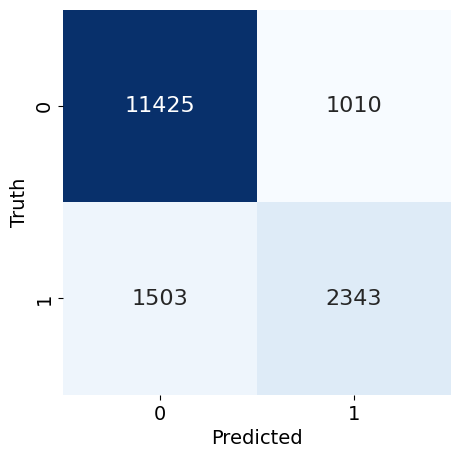

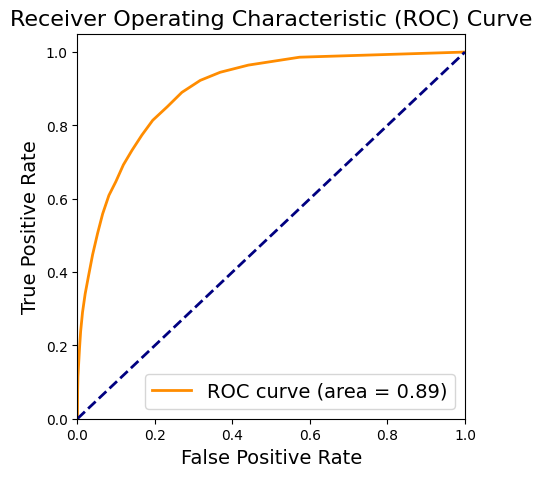

In [91]:
# base on the previous grid search
best_k = 23

# if redo grid search:
if do_grid_search:
    # create kNN classifier
    knn_classifier = KNeighborsClassifier()

    # define the parameter values that should be searched
    k_range = list(range(1, 32))
    param_grid = dict(n_neighbors=k_range)

    # instantiate the grid (n_jobs=-1 will use all available cores on your machine)
    grid = GridSearchCV(knn_classifier, param_grid, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)

    # fit the grid with data (this will take some time)
    grid.fit(x_train, y_train)

    # view the complete results (optional)
    print(grid.cv_results_)

    # examine the best model
    print(f'Best score: {grid.best_score_}')
    print(f'Best params: {grid.best_params_}')

    # # plot the results
    mean_test_scores = grid.cv_results_['mean_test_score']
    plt.figure()
    plt.plot(k_range, mean_test_scores, marker='o')
    plt.title('Grid Search Results')
    plt.xlabel('Value of K for kNN')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    # train kNN classifier with the best k value
    best_k = grid.best_params_['n_neighbors']

knn_classifier = KNeighborsClassifier(n_neighbors=best_k)

# get the current time
start_time = time.time()  
knn_classifier.fit(x_train, y_train)
# get the current time after running the fit method
end_time = time.time() 
# calculate the difference to get the time taken
elapsed_time = (end_time - start_time) * 1000
print(f"The time taken to run the fit method is: {elapsed_time:.2f} ms")

# check the accuracy of the classifier on the test data
y_pred = knn_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

# generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plotting the confusion matrix using Seaborn
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Truth', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.show()

# compute ROC curve and ROC area
y_pred_prob = knn_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Classification with DT

The time taken to run the fit method is: 423.49 ms
Accuracy: 86.35%
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12435
           1       0.77      0.60      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.77      0.79     16281
weighted avg       0.86      0.86      0.86     16281



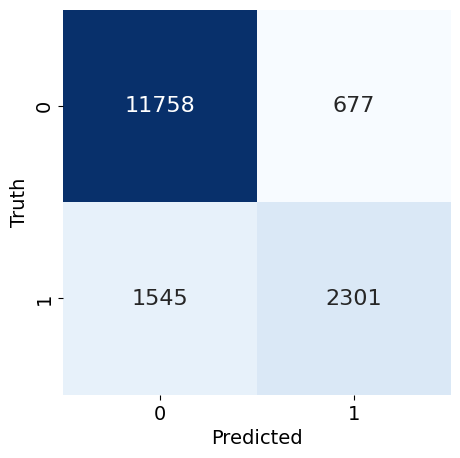

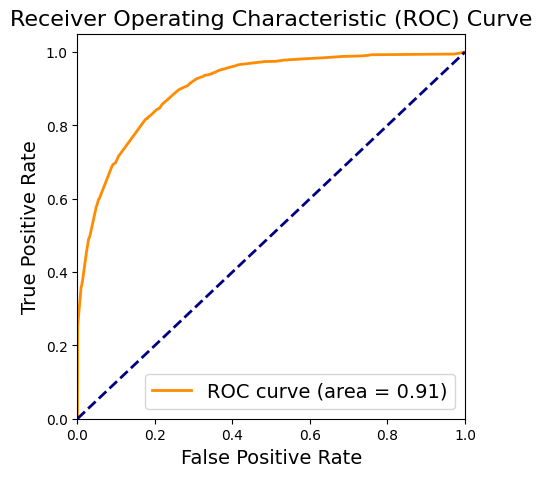

In [92]:
# base on the previous grid search
best_params = {
    'criterion': 'gini',
    'max_depth': 10, 
    'min_samples_leaf': 4, 
    'min_samples_split': 20, 
    'splitter': 'best'
}

# if redo grid search:
if do_grid_search:
    # create Decision Tree classifier
    dt_classifier = DecisionTreeClassifier(random_state=42)

    # define the parameter values that should be searched
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': list(range(1, 21)),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
    }

    # instantiate the grid (n_jobs=-1 will use all available cores on your machine)
    grid = GridSearchCV(dt_classifier, param_grid, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)

    # fit the grid with data (this will take some time)
    grid.fit(x_train, y_train)

    # view the complete results (optional)
    print(grid.cv_results_)

    # examine the best model
    print(f'Best score: {grid.best_score_}')
    print(f'Best params: {grid.best_params_}')

    # train Decision Tree classifier with the best parameters
    best_params = grid.best_params_

dt_classifier = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    splitter=best_params['splitter'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# get the current time
start_time = time.time()  
dt_classifier.fit(x_train, y_train)
# get the current time after running the fit method
end_time = time.time() 
# calculate the difference to get the time taken
elapsed_time = (end_time - start_time) * 1000
print(f"The time taken to run the fit method is: {elapsed_time:.2f} ms")

# check the accuracy of the classifier on the test data
y_pred = dt_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Truth', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.show()

y_pred_prob = dt_classifier.predict_proba(x_test)[:, 1]

# compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()
